In [1]:
import torch
from pathlib import Path

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import bliss

import bliss.models.encoder as encoder_lib
from bliss.models.decoder import ImageDecoder
from bliss.models import galaxy_net

from bliss import device, use_cuda
print(device)
print(use_cuda)

data_path = Path('../data/')

cuda
True


In [3]:
torch.manual_seed(2342)
np.random.seed(354)

# Model parameters

### PSF

In [4]:
n_bands = 1

In [5]:
# psf parameters 
psf_file = data_path.joinpath("fitted_powerlaw_psf_params.npy")
psf_params = torch.from_numpy(np.load(psf_file)).to(device)[0:n_bands]

### galaxy decoder

In [6]:
include_galaxy = True
if include_galaxy: 
    assert n_bands == 1, 'galaxy decoder only available for single band'
    gal_slen = 51
    latent_dim = 8
    decoder_file = '../data/galaxy_decoder_1_band.dat'
    dec = galaxy_net.CenteredGalaxyDecoder(gal_slen, latent_dim, n_bands=n_bands).to(device)
    dec.load_state_dict(torch.load(decoder_file, map_location=device))
    dec.eval()
    prob_galaxy = 1.
else: 
    dec = None
    prob_galaxy = 0.

# Define decoders

We define two decoders with different `slen`

In [7]:
# false for debugging
add_noise = False

In [8]:
slen1 = 40

# background
background = torch.zeros(n_bands, slen1, slen1, device=device)
background[:] = 686.

In [9]:
# the first decoder
image_decoder1 = ImageDecoder(dec,
                        psf_params,
                        background,
                        n_bands=n_bands,
                        slen=slen1,
                        prob_galaxy=prob_galaxy,
                        max_sources=1,
                        mean_sources=1,
                        min_sources=1,
                        f_min=1e4,
                        f_max=1e6,
                        alpha=0.5,
                        add_noise=add_noise)

In [10]:
# the second decoder, with a different `slen`
slen2 = slen1 * 2

# background
background2 = torch.zeros(n_bands, slen2, slen2, device=device)
background2[:] = 686.

image_decoder2 = ImageDecoder(dec,
                        psf_params,
                        background2,
                        n_bands=n_bands,
                        slen=slen2,
                        prob_galaxy=prob_galaxy,
                        max_sources=1,
                        mean_sources=1,
                        min_sources=1,
                        f_min=1e4,
                        f_max=1e6,
                        alpha=0.5,
                        add_noise=add_noise)

# Set parameters

In [11]:
batch_size = 1

In [12]:
params = image_decoder1.sample_parameters(batch_size)

In [13]:
# specify location
x0 = 20.5
x1 = 20.5
params['locs'][:, :, 0] =  x0 / slen1
params['locs'][:, :, 1] =  x1 / slen1

locs = params['locs']

# Render images

In [14]:
image1 = image_decoder1.render_images(
                            image_decoder1.max_sources,
                            params['n_sources'],
                            locs, 
                            params['galaxy_bool'],
                            params['galaxy_params'],
                            params['fluxes'])


In [15]:
np.sqrt(1681)

41.0

In [16]:
locs2 = locs * slen1 / slen2
image2 = image_decoder2.render_images(
                            image_decoder1.max_sources,
                            params['n_sources'],
                            locs2, 
                            params['galaxy_bool'],
                            params['galaxy_params'],
                            params['fluxes'])


### Plot

In [17]:
batch = 0
band = 0

In [18]:
%matplotlib inline

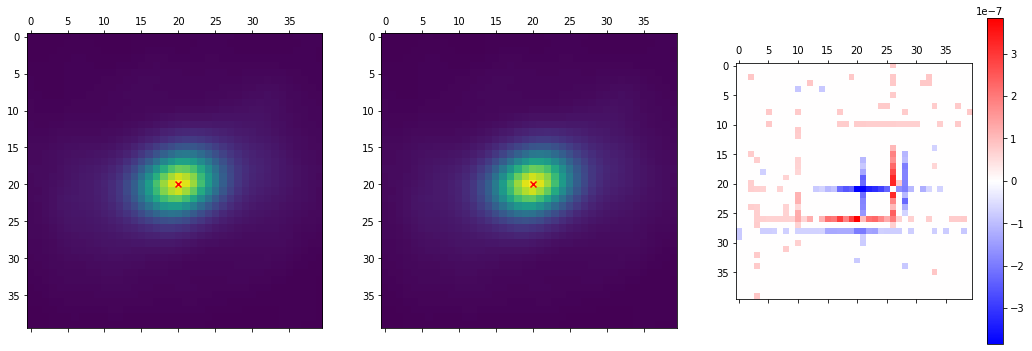

In [19]:
f, axarr = plt.subplots(1, 3, figsize=(18, 6))

# plot images
im1 = image1[batch, band].cpu().detach()
im2 = image2[batch, band, 0:slen1, 0:slen1].cpu().detach()
axarr[0].matshow(im1)
axarr[1].matshow(im2)

# plot locations 
axarr[0].scatter(x0 - 0.5, x1 - 0.5, color = 'red', marker = 'x')
axarr[1].scatter(x0 - 0.5, x1 - 0.5, color = 'red', marker = 'x')

# plto difference 
diff = (im1 - im2) / im1
vmax = diff.max().abs()
ax3 = axarr[2].matshow(diff, cmap = plt.get_cmap('bwr'), vmax = vmax, vmin = -vmax)
f.colorbar(ax3, ax = axarr[2])